In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
# load_img 함수: 이미지 불러오기
# img_to_array함수 : 불러온 이미지를 numpy 배열 (ndarray)로 변환
# local에서 사용하려면 Pillow를 설치해야 한다. (pip install Pillow)

# split data
from sklearn.model_selection import train_test_split
# library import
import re
import random
import xml.etree.ElementTree as et
from PIL import Image
 
import cv2 
from matplotlib.patches import Rectangle # 바운딩 박스를 그림

 # import the necessary packages
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
# from imutils import paths

import argparse
import datetime
# EfficientNetB0
from tensorflow.keras.applications import EfficientNetB0

# print(tf.__version__)
# print(keras.__version__)
np.random.seed(1)
tf.random.set_seed(1)

In [2]:
# 하이퍼 파라미터
LEARNING_RATE = 0.001
N_EPOCHS = 50
N_BATCHS = 50
N_CLASS = 4 # 클래스 개수
CLASS_MODE = 'categorical'
INPUT_SHAPE = (640, 360, 3) # 학습할 이미지 shape
IMAGE_SIZE = 224
IMAGE_SIZE2 = 224
########################### 모델에 맞춰 변경해야 한다!
FEATURE_SHAPE = (20, 15, 512)

BASE_PATH = ''
ORIGINAL_PATH = './data/original'
AUGMENT_PATH = './data/augmentImg'
train_dir = './inputdata_preprocessing/classedImg/train'
validation_dir = './inputdata_preprocessing/classedImg/val'
test_dir = './inputdata_preprocessing/classedImg/test'

In [2]:
# 데이터 증강
# shutil.rmtree(AUGMENT_PATH, ignore_errors=True) # 디렉토리 비우기

# for subpath in os.listdir(ORIGINAL_PATH):
#     os.makedirs(os.path.join(AUGMENT_PATH, subpath), exist_ok=True)
#     data_datagen = ImageDataGenerator(rescale=1/255,
#                                       rotation_range=3,
#                                       zoom_range=0.1,
#                                       height_shift_range=0.2,
#                                       width_shift_range=0.2,
#                                       fill_mode='nearest')
#     target_path = os.path.join(ORIGINAL_PATH, subpath)
#     filename_in_dir=[]
#     for (root, dirs, files) in os.walk(target_path):
#         print("root ",root, " dirs", dirs, " files ", files)
#         for fname in files:
#             full_fname = os.path.join(root, fname)
#             filename_in_dir.append(full_fname)
#     target_image_list = [fname for fname in filename_in_dir if os.path.splitext(fname)[-1]=='.png']
#     print("target_image_list ", target_image_list)
#     for file_image in target_image_list:
#         img = load_img(file_image)
#         x = img_to_array(img)
#         x = x[np.newaxis,...]

#         i=0
#         for batch in data_datagen.flow(x, save_to_dir=os.path.join(AUGMENT_PATH, subpath), save_prefix='aug', save_format='png'):
#             i += 1
#             if i > 2: # 데이터 증가시킬 양 결정.
#                 break

In [7]:
# 데이터 셋 나누기
# 기존데이터 디렉토리 지우기
shutil.rmtree(train_dir, ignore_errors=True)
shutil.rmtree(validation_dir, ignore_errors=True)
shutil.rmtree(test_dir, ignore_errors=True)

os.makedirs(train_dir,exist_ok=True)
os.makedirs(validation_dir,exist_ok=True)
os.makedirs(test_dir,exist_ok=True)

img_file_list = os.listdir(ORIGINAL_PATH)

for i in range(len(img_file_list)): # 라벨폴더별
    label = img_file_list[i]

    train_under_dir = os.path.join(train_dir, label)
    validation_under_dir = os.path.join(validation_dir, label)
    test_under_dir = os.path.join(test_dir,label)

    os.makedirs(train_under_dir, exist_ok=True)
    os.makedirs(validation_under_dir, exist_ok=True)
    os.makedirs(test_under_dir, exist_ok=True)

    tmp_img_path = os.path.join(ORIGINAL_PATH, label)
    img_list = os.listdir(tmp_img_path)
    train_len= int(len(img_list)*0.7) # 70% train data
    val_len = int(len(img_list)*0.9) # 20% val data, test = 10%
    random.shuffle(img_list)

    count = 0
    for img_name in img_list:
        if count < train_len:
            shutil.copy(os.path.join(tmp_img_path,img_name), os.path.join(train_under_dir, img_name))
        elif count < val_len:
            shutil.copy(os.path.join(tmp_img_path,img_name), os.path.join(validation_under_dir, img_name))
#             shutil.copy(os.path.join(tmp_img_path,img_name), os.path.join(validation_under_dir, img_name))
        else:
            shutil.copy(os.path.join(tmp_img_path,img_name), os.path.join(test_under_dir, img_name))
#             shutil.copy(os.path.join(tmp_img_path, img_name), os.path.join(test_under_dir, img_name))
        count+=1
# train, val, test 각폴더내 데이터 개수
data_cnts = []
for dirs in [train_dir, validation_dir, test_dir]:
    cnt = 0
    for (path, dir, files) in os.walk(dirs):
        cnt += len(files)
    data_cnts.append(cnt)
print(data_cnts)

[840, 240, 120]


In [3]:
def get_generators():
    '''
    train, validation, test generator를 생성해서 반환.
    train generator는 image 변환 처리
    '''
    # 상하좌우 이동, 확대, 회전 이미지로 증강
    train_datagen = ImageDataGenerator(rescale=1/255,
                                       rotation_range=3,
                                       zoom_range=0.2,
                                       height_shift_range=0.1,
                                       width_shift_range=0.1,
                                       fill_mode='nearest'
                                       )

    test_datagen = ImageDataGenerator(rescale=1/255) #validation/test에서 사용

    # generator 들 생성
    # 첫번째는 먼저 한동작이므로 동작과 비동작으로 바이너리 구분만
    train_generator = train_datagen.flow_from_directory(train_dir,
                                                        target_size=(IMAGE_SIZE2,IMAGE_SIZE),
                                                        batch_size=N_BATCHS,
                                                        class_mode=CLASS_MODE)
    val_generator = test_datagen.flow_from_directory(validation_dir,
                                                     target_size=(IMAGE_SIZE2,IMAGE_SIZE),
                                                     batch_size=N_BATCHS,
                                                     class_mode=CLASS_MODE)
    test_generator = test_datagen.flow_from_directory(test_dir,
                                                      target_size=(IMAGE_SIZE2,IMAGE_SIZE),
                                                      batch_size=N_BATCHS,
                                                      class_mode=CLASS_MODE)
    return train_generator, val_generator, test_generator

In [4]:
# 결과 출력 function
def plot_result(history, ymin=None, ymax=None):
    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.plot(range(1,N_EPOCHS+1), history.history['loss'], label="train_loss")
    plt.plot(range(1,N_EPOCHS+1), history.history['val_loss'], label="val_loss")
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    if ymin is not None and ymax is not None:
        plt.ylim(ymin,ymax)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1,N_EPOCHS+1), history.history['accuracy'], label="train_accuracy")
    plt.plot(range(1,N_EPOCHS+1), history.history['val_accuracy'], label="val_accuracy")
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if ymin is not None and ymax is not None:
        plt.ylim(ymin,ymax)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
def create_model():
    conv_base = MobileNetV2(#input_shape=(IMAGE_SIZE2,IMAGE_SIZE,3),
                            weights='imagenet',
                            include_top=False,
                            input_tensor=Input(shape=(IMAGE_SIZE2, IMAGE_SIZE,3))
                            )
    conv_base.trainable=False # 학습시 weight 최적화(update)를 하지 않도록 설정. => 모델 컴파일 전에 실행

    model = keras.Sequential()
    model.add(conv_base)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(rate=0.5))

    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization()) # 찾아보기
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization()) # 찾아보기


    # 출력
    model.add(layers.Dense(N_CLASS, activation='softmax'))

    return model

In [8]:
model = create_model()
model.summary()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy', metrics=['accuracy']
              )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               327936    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)              

In [9]:
train_iterator, validation_iterator, test_iterator = get_generators()

Found 840 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [10]:
# 학습 설정 콜백 함수
MODEL_PATH = './models'
callback_path = os.path.join(MODEL_PATH, 'save_model_{epoch:02d}.ckpt')
mc_callback = keras.callbacks.ModelCheckpoint(callback_path, monitor='val_loss', save_best_only=True)

In [11]:
history = model.fit(train_iterator,
                    epochs=N_EPOCHS,
                    steps_per_epoch=len(train_iterator),
                    validation_data=validation_iterator,
                    validation_steps=len(validation_iterator),
#                     callbacks=[mc_callback]
                    )

Epoch 1/50
17/17 [==============================] - 14s 530ms/step - loss: 1.3021 - accuracy: 0.4726 - val_loss: 0.8870 - val_accuracy: 0.5417

In [12]:
dtime = datetime.datetime.now()
ptime = dtime.strftime('%Y-%m-%d_%H-%M-%S')
print(ptime)

2021-06-23_12-53-16


In [13]:
# 모델 저장
t = datetime.datetime.now()
ttime = t.strftime('%Y-%m-%d_%H-%M-%S')
# t = datetime.datetime().now().strftime('%Y')
save_model_path = os.path.join(MODEL_PATH, f'MobileNetV2-{ttime}.h5')
model.save(save_model_path, save_format='h5')

# 모델 load
# model = keras.models.load_model(os.path.join(save_model_path, '파일'))

C:\Users\mein0\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [14]:
# test evaluation
model.evaluate(test_iterator)

3/3 [==============================] - 1s 199ms/step - loss: 0.5066 - accuracy: 0.7583


[0.5065643787384033, 0.7583333253860474]

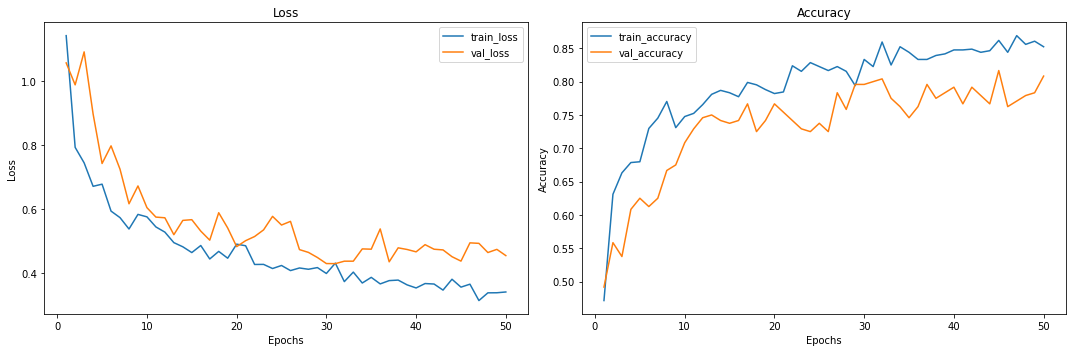

In [28]:
plot_result(history)